In [1]:
import import_ipynb
from Environments import Boxworld_DP
from Environments import run_experiments
from Environments import run_single_exp
import numpy as np
from collections import namedtuple
import matplotlib.pyplot as plt

# First define a namedtuple to hold useful information for actions
Action = namedtuple('Action', 'name index delta_i delta_j' )
up = Action('up', 0, -1, 0)    
down = Action('down', 1, 1, 0)    
left = Action('left', 2, 0, -1)    
right = Action('right', 3, 0, 1) 

# Use a dictionary to convert indices to actions using the index as a key
# Useful for sampling actions for a given state
index_to_actions = {}
for action in [up, down, left, right]:
    index_to_actions[action.index] = action 
    
# Helpful function to convert action in string format to the action object
str_to_actions = {}
for action in [up,down,left,right]:
    str_to_actions[action.name] = action

importing Jupyter notebook from Environments.ipynb


In [4]:
class Policy_DP():
    
    def __init__(self,environment,gamma):
        self.env = environment
        self.size_env= environment.size
        self.reward_matrix = environment.reward_matrix
        self.transition_matrix = environment.transition_matrix
        self.coord_to_index = environment.coord_to_index
        self.index_pairs_to_state = environment.index_pairs_to_state
        self.size_state_space = environment.size**4
        
        # Initialize policy to be a random one
        self.probability_actions = np.ones((self.size_state_space, 4))*0.25 
        
        # We initialize the values to 0
        self.values = np.zeros( self.size_state_space )   
        
        # Discount factor
        self.gamma = gamma
     
    # Function which samples an action, given a state
    def __call__(self,state):
        
        # Find the probabilities of actions for the given state
        prob_actions = self.probability_actions[state]
        
        # Randomly sample index from this
        index = np.random.choice(np.arange(prob_actions.size))
        return index_to_actions[index].name
    
    

    
    # Function that uses a given policy to evaluate the value functions for each state
    def iterative_policy_evaluation(self,n_sweeps):
        
        # Reset the values
        self.values = np.zeros(self.size_state_space)
        
        # Then use bellman expectation equation to iteratively update values
        for n in range(n_sweeps):
            
            self.values = np.sum(self.probability_actions * (self.reward_matrix + 
                                 self.gamma* np.dot(self.transition_matrix,self.values)), axis=1 )
            
    # ** Need to pass env in order to get current coordinates of box (in init would only get starting coords...)        
    def display_values(self,env):
        
        value_matrix = np.zeros( (self.size_env,self.size_env) )
        
        # Get index of box coordinates
        box_index = self.coord_to_index[env.position_box[0],env.position_box[1]]
            
        for i in range(1, self.size_env-1):
                for j in range(1, self.size_env-1):

                    agent_index = self.coord_to_index[i,j]
                    state = self.index_pairs_to_state[box_index,agent_index]
                    value_matrix[i,j] = self.values[state]
                        
        return value_matrix
    
    def greedy_improvement(self):
        
        # Get indices of 'best' actions
        argmax_actions = np.argmax(self.reward_matrix + self.gamma * np.dot(self.transition_matrix,self.values), axis=1 )
        
        #Then update policy for each state
        for state in range(self.size_state_space):
            
            greedy_index = argmax_actions[state]
            
            #But only update if this transition is possible!
            if self.transition_matrix[state][greedy_index].sum()!=0:
                
                self.probability_actions[state,:] = 0
                self.probability_actions[state,greedy_index] = 1
                
            
    
    #A function that iteratively evaluates and improves a policy 
    def policy_iteration(self, n_evaluations):
        
        self.iterative_policy_evaluation(n_evaluations)
        self.greedy_improvement()

# Example
Below, we apply a single iteration of policy improvement, after 25 sweeps of policy evaluation

X X X X X X X 
X E . . . E X 
X . . . . . X 
X . . A . . X 
X . . . . . X 
X ! . . B E X 
X X X X X X X 



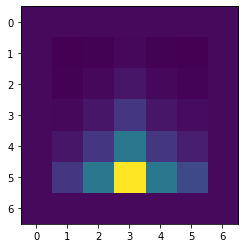

up
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0. -6. -6. -6. -6. -6.  0.]
 [ 0. -1. -1. -1. -1. -1.  0.]
 [ 0. -1. -1. -1. -1. -1.  0.]
 [ 0. -1. -1. -1. -1. -1.  0.]
 [ 0. -1. -1. -1. -1. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]]
down
[[  0.   0.   0.   0.   0.   0.   0.]
 [  0.  -1.  -1.  -1.  -1.  -1.   0.]
 [  0.  -1.  -1.  -1.  -1.  -1.   0.]
 [  0.  -1.  -1.  -1.  -1.  -1.   0.]
 [  0.  -1.  -1.  -1. -10.  -1.   0.]
 [  0.  -6.  -6.  -6.  -6.  -6.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]]
left
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0. -6. -1. -1. -1. -1.  0.]
 [ 0. -6. -1. -1. -1. -1.  0.]
 [ 0. -6. -1. -1. -1. -1.  0.]
 [ 0. -6. -1. -1. -1. -1.  0.]
 [ 0. -6. -1. -1. -1.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]]
right
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1. -1. -1. -1. -6.  0.]
 [ 0. -1. -1. -1. -1. -6.  0.]
 [ 0. -1. -1. -1. -1. -6.  0.]
 [ 0. -1. -1. -1. -1. -6.  0.]
 [ 0. -1. -1. 50. -1. -6.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]]


In [17]:
boxworld = Boxworld_DP(7)
boxworld.reset()
policy = Policy_DP(boxworld,gamma=0.4)

# Apply a single greedy improvement, after 25 sweeps
for i in range(25):
    values = policy.iterative_policy_evaluation(10)
    policy.greedy_improvement()

# Display values
boxworld.display()
vals = policy.display_values(boxworld)
plt.imshow( (vals - vals.min())/(vals.max() - vals.min()) )
plt.show()

# Display rewards
boxworld.print_reward_matrices()

In [18]:
all_rew, max_rew, mean_rew, var_rew = run_experiments(boxworld,policy,10)
print(f"Rewards: {all_rew} \nMax Reward: {max_rew} \nMean Reward: {mean_rew} \nVariance: {var_rew}" )

Rewards: [-87, -167, -1028, -312, -1353, 41, -1028, -2156, -857, -322] 
Max Reward: 41 
Mean Reward: -726.9 
Variance: 654.315894656396


# Improving the Policy 

Below, we see how policy iteration improves how well the agent performs the task. We use the mean reward over 20 experiments as measure of the agent's performance.

In [20]:
boxworld = Boxworld_DP(7)
gamma = 0.4 # Expect a high gamma to be better, as agent needs to be farsighted in an environment like this

policy = Policy_DP(boxworld,gamma)

# Let's now see how our agent does after repeatedly improving the policy
for n_improvements in range(20):
    
    values = policy.policy_iteration(n_evaluations=20)
    
    _, max_reward, mean_reward, var_reward = run_experiments(boxworld, policy, number_exp=20)
    
    print(n_improvements, mean_reward)

Time limit expired!
0 -1295.55
1 -702.8
2 -819.85
Time limit expired!
Time limit expired!
3 -1329.55
4 -696.0
5 -724.3
6 -1280.3
7 -932.7
8 -725.55
9 -1209.25
10 -677.5
11 -539.0
Time limit expired!
12 -889.0
13 -870.85
14 -623.1
15 -964.65
Time limit expired!
16 -1082.35
17 -691.35
18 -585.85
19 -1094.65


## Conclusion

The above results may seem strange, since there does not seem to be a clear improvement in the agent's performance. This could be due to the large variance in rewards, or even due to our choice of hyperparameters.

# Plots

Below is a plot of results over a number of environment sizes. For each size n, we create n environments and perform policy iteration n times. using 10 sweeps for the evaluation step. Then we run 5 episodes on each environment and calculate the mean reward over these episodes. Finally, we plot how the average reward changes as we increase the environment size.

**This time we use a higher value of gamma, as it makes sense that the agent should be relatively far-sighted in an environment like this. 

In [ ]:
n_environments_per_size=5
n_runs_per_environments=5
gamma = 0.9

mean_reward = []
std_reward = []
    
for size_envir in range(5,10):

    # heuristics
    n_improvement_steps = size_envir
    n_steps_policy_eval = 10
    
    total_rewards = []

    for n_envir in range(n_environments_per_size):

        boxworld = Boxworld_DP(size_envir)
        policy = Policy_DP(boxworld, gamma)
        
        for n_improvements in range(n_improvement_steps):
    
            policy.policy_iteration(n_steps_policy_eval)

        all_total_rewards, _, _, _ = run_experiments(boxworld, policy, n_runs_per_environments)

        total_rewards += all_total_rewards

    mean_reward.append( np.mean(total_rewards) )
    std_reward.append( np.std(total_rewards) )

mean_reward = np.asarray(mean_reward)
std_reward = np.asarray(std_reward)

plt.plot(range(5, 10), mean_reward, 'or')
plt.plot(range(5, 10), mean_reward, color = 'r')
plt.fill_between(range(5, 10), mean_reward - std_reward/2, mean_reward + std_reward/2,
             color='r', alpha=0.2)

plt.xlabel('Environment size')
plt.ylabel('Average reward')

plt.show()